## Dynamic Programming (Policy Iteration)

We will be solving the gridworld problem with dynamic programming. The agent will be dropped in a random position on the board and find its way to one of the corners. Each turn that passes the agent will receive a reward of -1 (incentivizing finding the terminal state as quickly as possible).

We will be evaluating the value functions w.r.t. random policy.  Note that the dynamics of the MDP is deterministic. Given a state and action, we know exactly what the next state will be (square above, to left, to right, or below) Likewise, the reward is known for every action, state combination.


<img src="imgs\DP_Policy_Iteration_Algorithm.PNG">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

GRID_SIZE = 4
GAMMA = 0.9
NONTERM_REWARD = -1
TERMINATION_STATE = [[0,0],[GRID_SIZE-1,GRID_SIZE-1]]
ACTIONS = [[-1,0],[1,0],[0,1],[0,-1]]
THETA = 1e-7
ITERATION_CUTOFF = 250

In [2]:
def get_state_reward(current_state, action):
    if current_state in TERMINATION_STATE:
        return current_state, 0
    
    next_state = np.array(current_state) + np.array(action)
    reward = NONTERM_REWARD
    if (-1 in next_state) or (GRID_SIZE in next_state):
        next_state = current_state
    return next_state, reward

def get_reward(current_state, action):
    _, reward = get_state_reward(current_state, action)
    return reward

def get_state(current_state, action):
    state, _ = get_state_reward(current_state, action)
    return state

def get_value(next_state, val_map):
    return val_map[next_state[0], next_state[1]]
    
def set_value(value, state, val_map):
    val_map[state[0], state[1]] = value
    return val_map
    
def initialize_state_values():
    """Simply initialize the value matrix and the state index
    """
    value_map = np.zeros((GRID_SIZE, GRID_SIZE))
    states = [[i, j] for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
    return states, value_map

def random_policy(current_state, value_map=None):
    return [1/len(ACTIONS) for i in range(len(ACTIONS))]

In [3]:
def policy_evaluation(policy, stop_delta=True, val_map = None, _print=True, ret_deltas=True):
    iteration = 0
    deltas = [] 
    delta = 0
    if val_map is None:
        states, value_map = initialize_state_values()
    else:
        states, _ = initialize_state_values()
        value_map = val_map
    
    stop_delta_flag = True
    while (stop_delta_flag):
        delta = 0
        if iteration > ITERATION_CUTOFF:
            break
        else:
            next_value_map = np.zeros((GRID_SIZE, GRID_SIZE))
            for state in states:
                v = get_value(state, value_map)
                updated_v = 0
                
                action_probabilities = policy(state, value_map=value_map)

                for i, action in enumerate(ACTIONS):
                    next_state, reward = get_state_reward(state, action)
                    updated_v += (action_probabilities[i])*(reward + (GAMMA*get_value(next_state, value_map)))
                    
                delta = max([delta, abs(v - updated_v)])
                next_value_map = set_value(updated_v, state, next_value_map)
                
            deltas.append(delta)
            value_map = next_value_map
            iteration+=1
            if _print and iteration in [1,2,1000]:
                print("Iteration {}: \nDelta: {}".format(iteration, round(delta,3)))
                print(value_map.round(3))
                print()
        if stop_delta:
            stop_delta_flag = THETA < delta
    if _print:        
        print("Iteration {}: \nDelta: {}".format(iteration, round(delta,3)))
        print(value_map.round(2))
        print()
    
    if ret_deltas:
        res = (value_map, deltas)
    else:
        res = value_map
    return res

In [4]:
print("-------------------------------------------------------------------")
print("Policy Evaluation on Grid World")
final_val_map_random, delta_random = policy_evaluation(random_policy, stop_delta=True)

-------------------------------------------------------------------
Policy Evaluation on Grid World
Iteration 1: 
Delta: 1.0
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

Iteration 2: 
Delta: 0.9
[[ 0.    -1.675 -1.9   -1.9  ]
 [-1.675 -1.9   -1.9   -1.9  ]
 [-1.9   -1.9   -1.9   -1.675]
 [-1.9   -1.9   -1.675  0.   ]]

Iteration 103: 
Delta: 0.0
[[ 0.   -5.28 -7.13 -7.65]
 [-5.28 -6.61 -7.18 -7.13]
 [-7.13 -7.18 -6.61 -5.28]
 [-7.65 -7.13 -5.28  0.  ]]



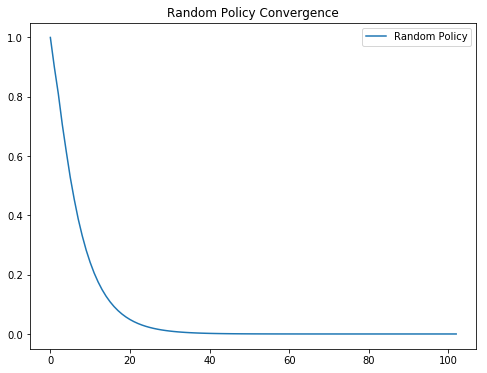

In [5]:
plt.figure(figsize=(8,6))
plt.title("Random Policy Convergence")
plt.plot(range(len(delta_random)), delta_random, label= "Random Policy")
plt.legend()
plt.show()

## Policy Improvement Theorem

There is a partial ordering among policies that we can use to compare two policies. Given to policies pi and pi', pi' is a better is as good or better than pi if for all states of the MDP:
<img src="imgs\policy_improvement_theorem2.PNG">



One way a policy can be improved is to create a new policy by performing greedy selection on the previous policies value function. We can prove that this new greedy policy is at least as good as the old policy by checking if for each state.
<img src="imgs\policy_improvement_theorem.PNG">

In the below code, we test whether applying greedy selection to the value function for the random policy will result in a new policy that is strictly better for all states.

In [6]:
def greedy_policy(current_state, value_map=None):
    """Returns the probability of next actions. (1 if no tie)"""
    possible_rewards = [get_reward(current_state, action)+(GAMMA*get_value(get_state(current_state, action), value_map)) for action in ACTIONS]
    max_r = max(possible_rewards)
    greedy_actions = [1/(np.array(possible_rewards)==max_r).sum() if r==max_r else 0 for r in possible_rewards]
    return greedy_actions

def did_policy_improve(state, value_map, new_policy):
    action_probabilities = new_policy(state, value_map)
    q_pi = 0 
    for i, action in enumerate(ACTIONS):
        next_state, reward = get_state_reward(state, action)
        q_pi += (action_probabilities[i])*(reward + (GAMMA*get_value(next_state, value_map)))
    return q_pi >= get_value(state, value_map)

In [7]:
print("-------------------------------------------------------------------")
print("Policy Improvement")
states, _ = initialize_state_values()
result = [[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]
for state in states:
    improved = did_policy_improve(state, final_val_map_random, greedy_policy)
    result[state[0]][state[1]] = improved

print("Is greedy selection better \nin the current state?", '\n')    
for row in result:
    print(row)

-------------------------------------------------------------------
Policy Improvement
Is greedy selection better 
in the current state? 

[True, True, True, True]
[True, True, True, True]
[True, True, True, True]
[True, True, True, True]


### Computing Optimal Policy

In [8]:
VAL_MAP = final_val_map_random
for i in range(1000):
    VAL_MAP = policy_evaluation(greedy_policy, stop_delta=True, val_map=VAL_MAP, _print=False, ret_deltas=False)
print("Optimal Value Function:")
print(VAL_MAP)

Optimal Value Function:
[[ 0.   -1.   -1.9  -2.71]
 [-1.   -1.9  -2.71 -1.9 ]
 [-1.9  -2.71 -1.9  -1.  ]
 [-2.71 -1.9  -1.    0.  ]]


In [9]:
def read_action(actions):
    res = ''
    names = ['U','D','R','L']
    for i, act in enumerate(actions):
        if act>0:
            res+=names[i]
    return res

states, _ = initialize_state_values()
optimal_actions = [[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]
for state in states:
    action = greedy_policy(state, value_map=VAL_MAP)
    optimal_actions[state[0]][state[1]] = read_action(action)
print('Optimal Policy:')
for row in optimal_actions:
    print(row)

Optimal Policy:
['UDRL', 'L', 'L', 'DL']
['U', 'UL', 'UDRL', 'D']
['U', 'UDRL', 'DR', 'D']
['UR', 'R', 'R', 'UDRL']


# Q-Learning

<img src="imgs\Q_Learning_algorithm.PNG">

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import random
from tqdm import tqdm_notebook
import pdb

In [11]:
def random_terminations(grid_size, num_holes=2):
    termination_states = []
    while len(termination_states)<=num_holes:
        hole = [randint(0,grid_size-1),randint(0,grid_size-1)]
        if hole not in termination_states:
            termination_states.append(hole)
    return termination_states

def get_state_reward(current_state, action):
    rando = random.random()
    if rando<SLIP_PROB: #slip
        next_state = np.array(current_state) + 2*np.array(action)
        if next_state[0]<=-1:
            next_state[0] = 0
        if next_state[1]<=-1:
            next_state[1] = 0
        if next_state[0]>=GRID_SIZE:
            next_state[0] = GRID_SIZE - 1
        if next_state[1]>=GRID_SIZE:
            next_state[1] = GRID_SIZE - 1
        if list(np.array(current_state) + np.array(action)) in TERMINATION_STATE:
            return list(next_state), TERM_REWARD #slipped into hole
    else:
        next_state = np.array(current_state) + np.array(action)

    next_state = list(next_state)
    if next_state in TERMINATION_STATE:
        return next_state, TERM_REWARD #hole
    else:
        return next_state, NONTERM_REWARD

def possible_actions(state):
    actions =[]
    if state[0]!=0:
        actions.append([-1,0])
    if state[1]!=0:
        actions.append([0,-1]) 
    if state[0]!=GRID_SIZE-1:
        actions.append([1,0])
    if state[1]!=GRID_SIZE-1:
        actions.append([0,1])
    return actions

    
def initialize_Q_matrix():
    Q_matrix = dict()
    states = [[i, j] for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
    for state in states:
        actions = possible_actions(state)
        for action in actions:
            Q_matrix[str(state[0])+str(state[1])+str(action)] = random.random()
    return Q_matrix


def greedy_policy(current_state, Q_matrix=None, epsilon=0.05):
    """Returns the probability of next actions. (1 if no tie)"""
    actions = possible_actions(current_state)
    rando = random.random()
    if rando<epsilon:#random exploration
        return random.choice(actions)
    possible_rewards = [Q_matrix[str(current_state[0])+str(current_state[1])+str(action)] for action in actions]
    i, max_r = max(enumerate(possible_rewards), key=lambda x: x[1])
    greedy_action = actions[i]
    return greedy_action


def read_action(actions):
    names = ['U','D','R','L']
    if action ==[0,1]:
        return 'R'
    if action ==[1,0]:
        return 'D'
    if action ==[0,-1]:
        return 'L'
    if action ==[-1,0]:
        return 'U'

In [12]:
def Q_Learn(num_iterations=1000):
    iteration = 0
    states = [[i, j] for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
    
    Q_matrix = initialize_Q_matrix()
    while (iteration<num_iterations):
        iteration+=1
        epsilon = 1 - iteration/(num_iterations/2) #agent explores at start
        current_state = random.choice(states)
        reward = 0
        moves=0
        while reward!=TERM_REWARD:
            if moves>2000:
                break
            action = greedy_policy(current_state, Q_matrix=Q_matrix, epsilon=epsilon)
            next_state, reward = get_state_reward(current_state, action)
            previous_Q = Q_matrix[str(current_state[0])+str(current_state[1])+str(action)]
            next_Q = Q_matrix[str(next_state[0])+str(next_state[1])+str(greedy_policy(next_state, Q_matrix=Q_matrix, epsilon=epsilon))]
            update = (1-ALPHA)*previous_Q + ALPHA*(reward+GAMMA*next_Q)
            Q_matrix[str(current_state[0])+str(current_state[1])+str(action)] = update
            current_state = next_state
            moves+=1
    return Q_matrix

In [15]:
print("-------------------------------------------------------------------")
print("Q-Learning on Ice Skating Rink")

GRID_SIZE = 5
TERMINATION_STATE = random_terminations(GRID_SIZE, num_holes=2) 
SLIP_PROB = 0.2

NONTERM_REWARD = 100
TERM_REWARD = -1000

ALPHA = 0.1
GAMMA = 0.3

states = [[i, j] for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
rink = [[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]
for state in states:
    if state in TERMINATION_STATE:
        rink[state[0]][state[1]] = 'X'
    else:
        rink[state[0]][state[1]] = ' '

print("Rink:")
for row in rink:
    print(row)

Q_matrix = Q_Learn(num_iterations=500)

optimal_action = [[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]
for state in states:
    action = greedy_policy(state, Q_matrix=Q_matrix, epsilon=0)
    if state in TERMINATION_STATE:
        optimal_action[state[0]][state[1]] = 'X'
    else:
        optimal_action[state[0]][state[1]] = read_action(action)
print('Optimal Policy:')
for row in optimal_action:
    print(row)

-------------------------------------------------------------------
Q-Learning on Ice Skating Rink
Rink:
[' ', ' ', ' ', ' ', ' ']
['X', 'X', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', 'X']
[' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ']
Optimal Policy:
['R', 'R', 'R', 'D', 'L']
['X', 'X', 'R', 'U', 'U']
['D', 'D', 'D', 'D', 'X']
['D', 'R', 'D', 'D', 'L']
['R', 'R', 'L', 'L', 'L']
